In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor #ToTensor is 20 dimension matrix

# Preparing the dataset

In [ ]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5046500.60it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 161764.89it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1529957.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 6665685.36it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [ ]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [ ]:
train_data.targets.size()

torch.Size([60000])

In [ ]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

# Process the data into batches

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train': DataLoader(train_data,
                        batch_size = 100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size = 100,
                        shuffle=True,
                        num_workers=1)
}


In [ ]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x78a2ec1fbe50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x78a2ec1fb430>}

# Structure of CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional 2d Layer
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #(Channel in, Channel out)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() #Regulirazation layer -> deactivates certain nodes at the network so that we don't always use them during training.

        # Fully Connected Layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) #last layer should be 10 as it goes from 0 to 9.

    #Calling the Activation function
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #Calling reLu and max_pooling func
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #Call the dropout function
        x = x.view(-1,320) #20*4*4 neurons
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # calling dropout func only during training
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) #dim=1 #Probability for each individual digit.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #to make it work faster.

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_indx,(data,target) in enumerate (loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() #Set the gradient to zero  before we do th eback propogation
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward() #Calculate the gradient
    optimizer.step() #Update the weights
    if batch_indx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_indx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_indx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')
def test():
  model.eval()
  test_loss =0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1] # maximum value is the prediction
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loaders['test'].dataset)
  print(f'\n Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n')

In [ ]:
for epoch in range(1,11):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	2.317786
Train Epoch: 1 [2000/60000 (3%)]	2.170158
Train Epoch: 1 [4000/60000 (7%)]	1.662817
Train Epoch: 1 [6000/60000 (10%)]	1.072359
Train Epoch: 1 [8000/60000 (13%)]	1.191406
Train Epoch: 1 [10000/60000 (17%)]	0.698225
Train Epoch: 1 [12000/60000 (20%)]	0.706581
Train Epoch: 1 [14000/60000 (23%)]	0.420958
Train Epoch: 1 [16000/60000 (27%)]	0.683893
Train Epoch: 1 [18000/60000 (30%)]	0.605017
Train Epoch: 1 [20000/60000 (33%)]	0.435675
Train Epoch: 1 [22000/60000 (37%)]	0.376823
Train Epoch: 1 [24000/60000 (40%)]	0.369738
Train Epoch: 1 [26000/60000 (43%)]	0.302947
Train Epoch: 1 [28000/60000 (47%)]	0.446727
Train Epoch: 1 [30000/60000 (50%)]	0.466554
Train Epoch: 1 [32000/60000 (53%)]	0.414263
Train Epoch: 1 [34000/60000 (57%)]	0.447245
Train Epoch: 1 [36000/60000 (60%)]	0.400908
Train Epoch: 1 [38000/60000 (63%)]	0.312487
Train Epoch: 1 [40000/60000 (67%)]	0.267919
Train Epoch: 1 [42000/60000 (70%)]	0.348097
Train Epoch: 1 [44000/60000 (73%)]	0.464440

In [ ]:
device

device(type='cpu')

Prediction: 7


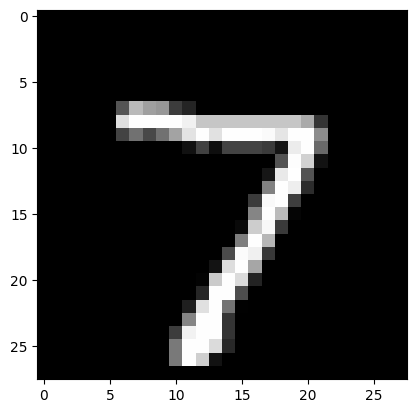

In [ ]:
import matplotlib.pyplot as plt
model.eval()

data , target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

pred = output.data.argmax(dim = 1, keepdim=True).item()

print(f'Prediction: {pred}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

Prediction: 2


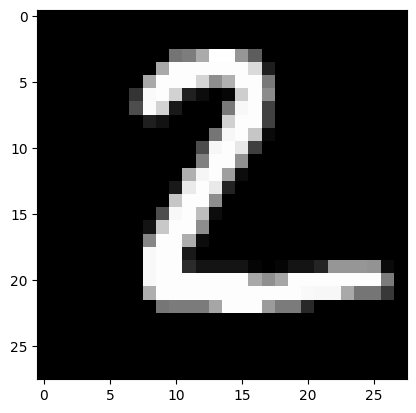

In [ ]:
model.eval()

data , target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)

pred = output.data.argmax(dim = 1, keepdim=True).item()

print(f'Prediction: {pred}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()